In [16]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


In [17]:
keep_all = pd.read_csv('keep_all.csv')
# Load models later
after_handoff_model = joblib.load("after_handoff_model.pkl")
after_catch_model = joblib.load("after_catch_model.pkl")
after_all_model = joblib.load("after_all_model.pkl")

In [18]:
features = ['s', 'a', 'o', 'dir',
       'ball_carrier_speed',
       'ball_carrier_acceleration',
       'ball_carrier_dir', 'ball_carrier_orientation', 'ball_carrier_height',
       'ball_carrier_weight', 'distance_to_ball_carrier',
       'defender_influence', 'blocker_influence', 'weight_diff',
       'height_diff', 'speed_diff', 'acc_diff']


keep_all['prediction'] = after_catch_model.predict(keep_all[features])
keep_all['probability'] = after_catch_model.predict_proba(keep_all[features])[:, 1]

In [19]:
keep_all['prediction'] = (keep_all['probability'] > 0.75).astype(int)
predicted_tackles = keep_all.groupby(['playId', 'frameId', 'displayName_x', 'gameId', 'position'])['probability'].sum()
actual_tackles = keep_all.groupby(['playId', 'frameId', 'displayName_x', 'gameId', 'position'])['play_made'].sum()

[84]


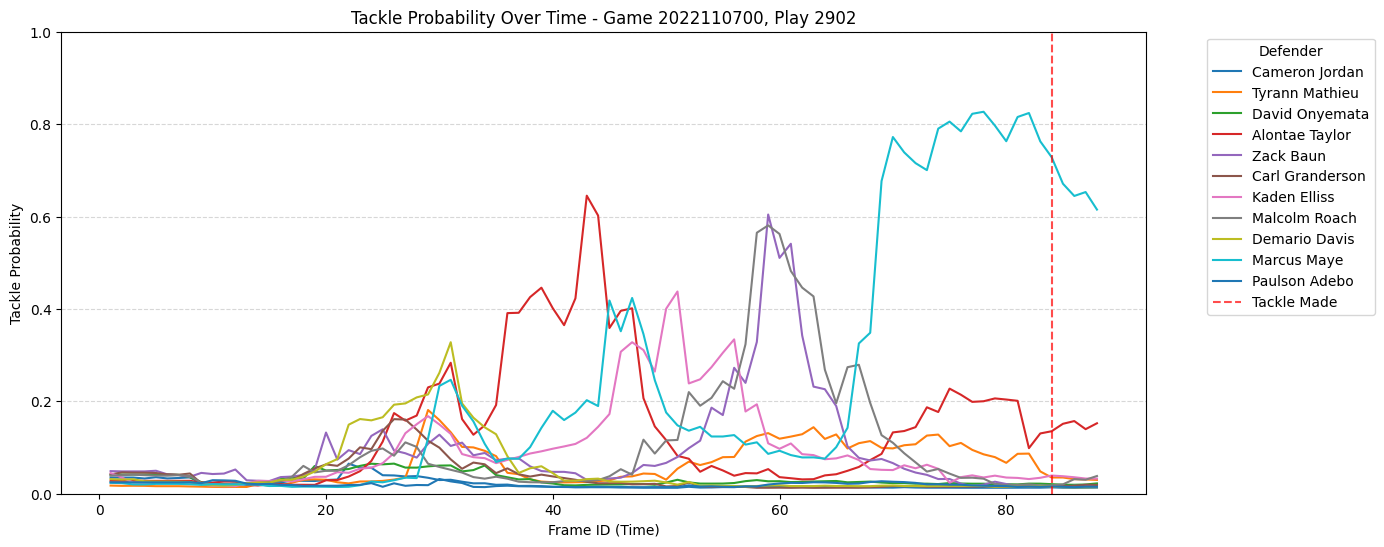

In [ ]:
game_id = 2022110700  # Replace with the actual game ID
play_id = 2902  # Replace with the actual play ID

play_data = keep_all[
    (keep_all['gameId'] == game_id) &
    (keep_all['playId'] == play_id)
]

play_data['ballCarrierDisplayName']

# Sort by frameId for proper time progression
play_data = play_data.sort_values(by='frameId')

# Get the frame where the tackle was made (if any)
tackle_frames = play_data[(play_data['event'] == 'tackle') | (play_data['event'] == 'assist')]['frameId'].unique()
print(tackle_frames)

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=play_data,
    x='frameId',
    y='probability',
    hue='displayName_x',
    palette='tab10'
)

# Draw vertical lines for frames where a tackle was made
for frame in tackle_frames:
    plt.axvline(x=frame, color='red', linestyle='--', alpha=0.7, label='Tackle Made' if frame == tackle_frames[0] else "")


# Labels and title
plt.xlabel('Frame ID (Time)')
plt.ylabel('Tackle Probability')
plt.title(f'Tackle Probability Over Time - Game {game_id}, Play {play_id}')
plt.legend(title="Defender", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.ylim(0, 1)


# Show the plot
plt.show()

In [22]:
keep_all['prediction'] = (keep_all['probability'] > 0.75).astype(int)
predicted_tackles = keep_all.groupby(['playId', 'frameId', 'displayName_x', 'gameId', 'position'])['probability'].sum()
actual_tackles = keep_all.groupby(['playId', 'frameId', 'displayName_x', 'gameId', 'position'])['play_made'].sum()
predicted_tackles = predicted_tackles.reset_index()
actual_tackles = actual_tackles.reset_index()


In [23]:
combined = pd.merge(predicted_tackles, actual_tackles, on = ['displayName_x', 'playId', 'frameId', 'gameId', 'position']).reset_index()
combined['TOE'] = combined['play_made'] - combined['probability']

In [24]:
TOE_ranking = combined.groupby(['displayName_x', 'position'])['TOE'].sum().reset_index().sort_values('TOE', ascending=False).head(50)
linebacker_toe = TOE_ranking[TOE_ranking['position'].isin(['ILB', 'OLB'])].sort_values('TOE', ascending=False)
secondary_toe = TOE_ranking[TOE_ranking['position'].isin(['FS', 'SS', 'CB'])].sort_values('TOE', ascending=False)